# Project 5: Improved Regularization of Convolutional Neural Networks

## 1. Resnet-20

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


In [ ]:
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20_rot(nn.Module):
    def __init__(self):
        super(ResNet20_rot, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self.blocks(16, 16, 3, stride=1)
        self.layer2 = self.blocks(16, 32, 3, stride=2)
        self.layer3 = self.blocks(32, 64, 3, stride=2)
        self.fc = nn.Linear(64, 10)
        self.fc_rotation = nn.Linear(64, 4) #rotation
        self.apply(_weights_init)

    def blocks(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i in strides:
            layers.append(ResidualBlock(in_channels, out_channels, i))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out_classification = self.fc(out)
        out_rotation = self.fc_rotation(out) #rotation
        return out_classification, out_rotation

## 2. Data Processing

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

class CIFAR10WithRotation(Dataset):
    def __init__(self, root, train, transform):
        self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transform)
        self.rotations = [0, 90, 180, 270]

    def __len__(self):
        return len(self.dataset) * len(self.rotations)

    def __getitem__(self, idx):
        image, label = self.dataset[idx % len(self.dataset)]
        rotation_idx = idx // len(self.dataset)
        rotation_angle = self.rotations[rotation_idx]
        rotated_image = transforms.functional.rotate(image, rotation_angle)
        return rotated_image, label, rotation_idx


normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])


train_loader = DataLoader(
        CIFAR10WithRotation(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)




100%|██████████| 170498071/170498071 [00:03<00:00, 49320974.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 3. Model Training

In [ ]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet20_rot().to(device)

INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

In [ ]:
import os
EPOCHS = 200
DECAY_EPOCHS = [60,120,160]#decay epoch change according to essay
DECAY = 0.2
LAMBDA = 0.1 #rotation
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
best_val_acc_loss = 0
train_accs=[]
train_losses=[]
val_accs=[]
val_losses=[]
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    if i in DECAY_EPOCHS:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    model.train()
    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0
    train_loss = 0

    for batch_idx, (inputs, targets, rotations) in enumerate(train_loader):
        inputs, targets, rotations = inputs.to(device), targets.to(device), rotations.to(device) #rotation

        outputs, rotation_outputs = model(inputs)
        loss = criterion(outputs, targets) + LAMBDA * criterion(rotation_outputs, rotations) #rotation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += predicted.eq(targets).sum().item()


    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_accs.append(avg_acc)
    train_losses.append(avg_loss)


    model.eval()
    total_examples = 0
    correct_examples = 0

    val_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    val_accs.append(avg_acc)
    val_losses.append(avg_loss)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        best_val_acc_loss = avg_loss
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'rotation.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f} with loss: {best_val_acc_loss:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.5052, Training accuracy: 0.4932
Validation loss: 1.2536, Validation accuracy: 0.5729
Saving ...

Epoch 1:
Training loss: 1.0307, Training accuracy: 0.6652
Validation loss: 1.1194, Validation accuracy: 0.6208
Saving ...

Epoch 2:
Training loss: 0.8895, Training accuracy: 0.7156
Validation loss: 1.0228, Validation accuracy: 0.6544
Saving ...

Epoch 3:
Training loss: 0.8099, Training accuracy: 0.7412
Validation loss: 0.8177, Validation accuracy: 0.7240
Saving ...

Epoch 4:
Training loss: 0.7539, Training accuracy: 0.7617
Validation loss: 0.8194, Validation accuracy: 0.7290
Saving ...

Epoch 5:
Training loss: 0.7158, Training accuracy: 0.7745
Validation loss: 0.8903, Validation accuracy: 0.6989

Epoch 6:
Training loss: 0.6890, Training accuracy: 0.7834
Validation loss: 0.8357, Validation accuracy: 0.7264

Epoch 7:
Training loss: 0.6614, Training accuracy: 0.7911
Validation loss: 0.7367, Validation accuracy: 0.7475
Saving ...

Epoch 8:
Training

## 4.

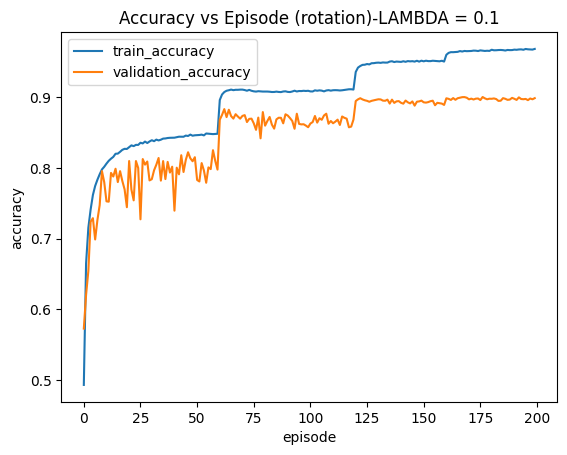

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(200),train_accs,label='train_accuracy')
plt.plot(range(200),val_accs,label='validation_accuracy')
plt.xlabel('episode')
plt.ylabel('accuracy')
plt.title('Accuracy vs Episode (rotation)-LAMBDA = 0.1')
plt.legend()
plt.show()

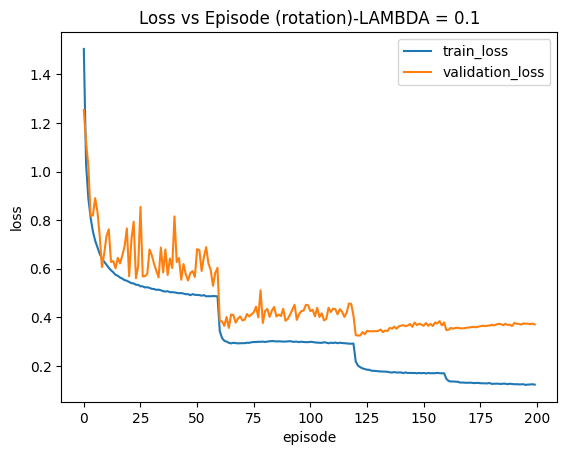

In [ ]:
plt.plot(range(200),train_losses,label='train_loss')
plt.plot(range(200),val_losses,label='validation_loss')
plt.xlabel('episode')
plt.ylabel('loss')
plt.title('Loss vs Episode (rotation)-LAMBDA = 0.1')
plt.legend()
plt.show()